In [1]:
# https://arxiv.org/pdf/1703.09137.pdf
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'Init-inject'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/IHR-NomDB'
LABELS_PATH = r'../../Dataset/IHR-NomDB/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=1).remove_rare_chars(1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 101533
- Number of labels found: 101533
- Number of unique characters: 13168
- Characters present: {'之': 8193, '以': 4931, '月': 4007, '人': 3927, '十': 3611, '年': 3381, '不': 3263, '帝': 2955, '二': 2722, '大': 2641, '有': 2634, '日': 2561, '為': 2548, '其': 2537, '公': 2476, '兵': 2469, '等': 2404, '固': 2381, '於': 2311, '如': 2252, '國': 2194, '時': 2171, '官': 2160, '太': 2153, '爲': 2142, '子': 2140, '一': 2136, '天': 2077, '王': 2061, '軍': 2052, '而': 2019, '三': 1981, '事': 1955, '吏': 1942, '明': 1910, '朱': 1880, '使': 1825, '阮': 1818, '至': 1808, '曰': 1791, '及': 1646, '者': 1638, '文': 1631, '㐌': 1617, '安': 1612, '臣': 1601, '所': 1600, '行': 1569, '埃': 1563, '黎': 1511, '麻': 1494, '上': 1485, '皇': 1469, '也': 1469, '士': 1462, '命': 1444, '民': 1424, '是': 1418, '中': 1409, '自': 1407, '𢚸': 1387, '四': 1354, '五': 1346, '生': 1333, '道': 1331, '爫': 1319, '下': 1293, '郡': 1249, '元': 1243, '山': 1214, '渃': 1201, '𠊛': 1192, '宗': 1174, '莫': 

## Data constants and input pipeline

In [5]:
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
START_CHAR = '[START]'
END_CHAR = '[END]' 

In [6]:
from loader import DataHandler
data_handler = DataHandler(
    dataset, 
    img_size = (HEIGHT, WIDTH), 
    padding_char = PADDING_CHAR,
    start_char = START_CHAR,
    end_char = END_CHAR
)

In [7]:
MAX_LENGTH = data_handler.max_length
START_TOKEN = data_handler.start_token
END_TOKEN = data_handler.end_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 32

## Visualize the data

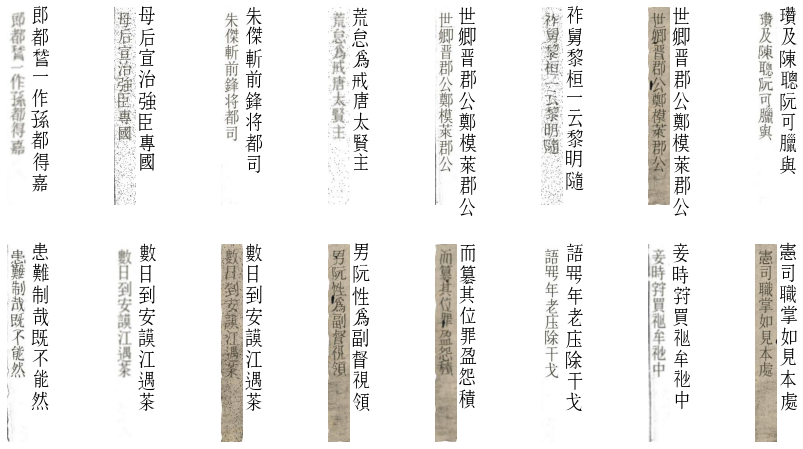

In [8]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 8),
    font_path = FONT_PATH, 
    text_x = WIDTH + 3
)

# Define model components

In [9]:
from tensorflow.keras.layers import Input, Embedding, Dense, GRU, Flatten, Add
from layers import custom_cnn
EMBEDDING_DIM = 512
UNITS = 512

## The CNN block

In [10]:
def FeaturesExtractor(imagenet_model=None, imagenet_output_layer=None, name='FeaturesExtractor'):
    # CNN block
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (2, 2)}, 

            # Last Conv blocks with 2x2 kernel but without no padding and pooling layer
            'block5': {'num_conv': 2, 'filters': 512, 'pool_size': None}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before adding output to RNN
    cnn_output = Dense(UNITS, name='cnn_output')(Flatten()(x))
    return tf.keras.Model(inputs=image_input, outputs=cnn_output, name=name)

## The RNN block

In [11]:
def TextProcessor(features_shape, name='TextProcessor'):
    partial_seq_input = Input(shape=(MAX_LENGTH - 1,), dtype='int64', name='partial_caption')
    features_input = Input(shape=features_shape, name='image_features')
    rnn_output = GRU(UNITS, name='rnn_output')(
        Embedding(VOCAB_SIZE, EMBEDDING_DIM)(partial_seq_input), 
        initial_state = features_input
    )
    x = Add(name='skip_connection')([features_input, rnn_output])
    y_pred = Dense(VOCAB_SIZE, name='prediction')(x)
    return tf.keras.Model(inputs=[partial_seq_input, features_input], outputs=y_pred, name=name)

# Build the model

In [12]:
from models import get_imagenet_model, EarlyBindingCaptioner
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

In [13]:
cnn_block = FeaturesExtractor(imagenet_model, imagenet_output_layer)
rnn_block = TextProcessor(cnn_block.output.shape[1:])
model = EarlyBindingCaptioner(cnn_block, rnn_block, data_handler)

In [14]:
cnn_block.summary(line_length=100)
print()
rnn_block.summary(line_length=100)

Model: "FeaturesExtractor"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 image (InputLayer)                          [(None, 432, 48, 3)]                    0              
                                                                                                    
 block1_conv1 (Conv2D)                       (None, 432, 48, 64)                     1792           
                                                                                                    
 block1_bn1 (BatchNormalization)             (None, 432, 48, 64)                     256            
                                                                                                    
 block1_relu1 (Activation)                   (None, 432, 48, 64)                     0              
                                                                

                                                                    'rnn_output[0][0]']             
                                                                                                    
 prediction (Dense)              (None, 13172)         6757236     ['skip_connection[0][0]']        
                                                                                                    
Total params: 15,077,236
Trainable params: 15,077,236
Non-trainable params: 0
____________________________________________________________________________________________________


# Training

In [15]:
train_idxs = list(range(int(dataset.size * 0.8)))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 81226
Number of validate samples: 20307


In [16]:
import random
random.seed(2022)
random.shuffle(train_idxs)
random.shuffle(valid_idxs)

In [17]:
# When run on a small RAM machine, you can set use_cache=False to 
# not run out of memory but it will slow down the training speed
train_tf_dataset = data_handler.prepare_tf_dataset(
    train_idxs, BATCH_SIZE, drop_remainder=True
)
valid_tf_dataset = data_handler.prepare_tf_dataset(
    valid_idxs, BATCH_SIZE, drop_remainder=True
)

## Callbacks

In [18]:
from callbacks import EarlyStoppingWithStuck
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_lr = 1e-6, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Train the IHR-NomDB dataset

In [19]:
from losses import MaskedLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [20]:
model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [ 
        SequenceAccuracy(), 
        CharacterAccuracy(),  
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)

In [21]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [reduce_lr_callback, early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
2538/2538 [==============================] - 396s 151ms/step - loss: 4.4689 - seq_acc: 0.0000e+00 - char_acc: 0.1946 - lev_distance: 0.7445 - val_loss: 5.0949 - val_seq_acc: 0.0000e+00 - val_char_acc: 0.1843 - val_lev_distance: 0.7917 - lr: 2.0000e-04
Epoch 2/100
2538/2538 [==============================] - 377s 148ms/step - loss: 3.6553 - seq_acc: 7.2646e-04 - char_acc: 0.2928 - lev_distance: 0.6892 - val_loss: 4.3602 - val_seq_acc: 0.0000e+00 - val_char_acc: 0.2371 - val_lev_distance: 0.7367 - lr: 2.0000e-04
Epoch 3/100
2538/2538 [==============================] - 378s 149ms/step - loss: 2.4264 - seq_acc: 0.0055 - char_acc: 0.4256 - lev_distance: 0.5619 - val_loss: 3.8717 - val_seq_acc: 0.0000e+00 - val_char_acc: 0.2927 - val_lev_distance: 0.6657 - lr: 2.0000e-04
Epoch 4/100
2538/2538 [==============================] - 379s 150ms/step - loss: 1.5723 - seq_acc: 0.0229 - char_acc: 0.5687 - lev_distance: 0.4211 - val_loss: 3.0577 - val_seq_acc: 4.9290e-05 - val_char_acc: 0.3

## Save the training results

In [22]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_lev_distance"][best_epoch]}')

- Loss on validation	: 1.7149944305419922
- Sequence accuracy	: 0.0660981833934784
- Character accuracy	: 0.6913390159606934
- Levenshtein distance	: 0.28216132521629333


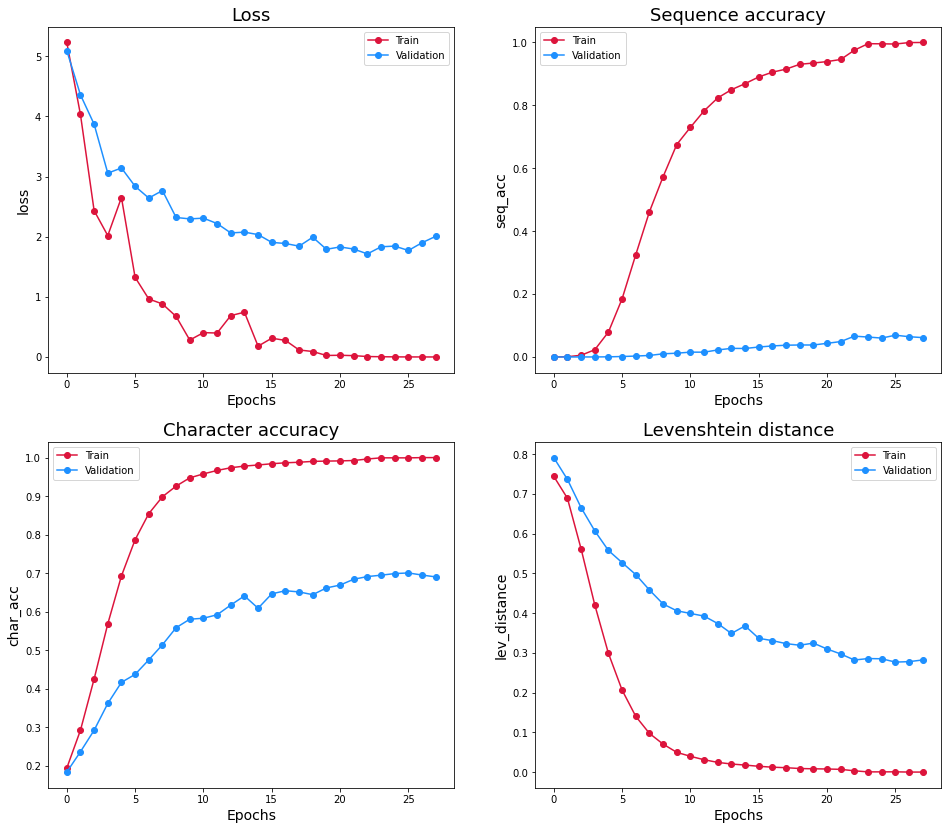

In [24]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.cnn_block.save_weights(f'{APPROACH_NAME}_cnn.h5')
model.rnn_block.save_weights(f'{APPROACH_NAME}_rnn.h5')

# Inference

In [29]:
cnn_block = FeaturesExtractor(imagenet_model, imagenet_output_layer)
rnn_block = TextProcessor(cnn_block.output.shape[1:])
cnn_block.load_weights(f'{APPROACH_NAME}_cnn.h5')
rnn_block.load_weights(f'{APPROACH_NAME}_rnn.h5')

In [30]:
reset_model = EarlyBindingCaptioner(cnn_block, rnn_block, data_handler)
reset_model.compile(
    optimizer = Adam(LEARNING_RATE), 
    loss = MaskedLoss(), 
    metrics = [
        SequenceAccuracy(),
        CharacterAccuracy(),
        LevenshteinDistance(normalize=True, name='lev_distance')
    ]
)
reset_model.evaluate(valid_tf_dataset)

634/634 [==============================] - 51s 72ms/step - loss: 2.0638 - seq_acc: 0.0661 - char_acc: 0.6913 - lev_distance: 0.2822


[0.0660981833934784,
 0.6913390159606934,
 0.28216132521629333,
 1.7149944305419922]

## On test dataset

Batch 01:
- True: {1: '二十日詔自今凣士人', 2: '及春秋髙而理明德', 3: '事其求封辝畧日國人徧', 4: '告立皇太子并賜綵幣', 5: '是皆揭標的於當時', 6: '因以上褚五十衣中褚', 7: '如各衙門應差捕得', 8: '脩政事有所舛紊人', 9: '帝親征何洞等四十九', 10: '下令各依圖次而退', 11: '咍𢶢𦷾渚底咹\U000f12d4𣈜𬧻', 12: '賭博之術不足以施', 13: '不能\U000f0c46\U000f0c47教士卒甚銳', 14: '命朝臣舉縣官聀有', 15: '至是令人排辨香花', 16: '及長容貌環偉聰明過', 17: '六月色旨禮部議定民', 18: '黎志兵部上書定功伯', 19: '冬十月詔傳位於皇太子', 20: '文武臣僚見者流涕', 21: '恩州阮啟使其子來行', 22: '長子昔以正位東宫', 23: '詔諸軍民不得服北人', 24: '上曰爾子幾人乎對', 25: '其村商賣怒廊百公', 26: '故合格黄袍者止八十', 27: '茂洽見有羙色心中悅', 28: '揮使掌衛事兼知豊祜堂', 29: '舍江至安决黔皷山駐營', 30: '後倚蘭夫人有娠生皇子', 31: '為以妾前年又𭁈宮女阮', 32: '號有厲致眾於朋來'}
- Pred: {1: '二十日詔日令九十日', 2: '及春秋髙而儂明德', 3: '事其求封詳畧旦圓財讀', 4: '告立皇并子并賜皇監', 5: '是皆禍糧財於當時', 6: '因以上海五十五', 7: '如各衙門應差鴻西', 8: '脩政事有所效等人', 9: '帝親征何領等四十閑', 10: '下令各依圖伏而依', 11: '咍拯𦷾渚底咹㖂㗂𦷾', 12: '膽博之雨不足以𠑬', 13: '不能月𭛁殺士卒救𭛁', 14: '命朝臣興縣官聀有', 15: '至是令人排排香花', 16: '及長弄瘴填洪地明哨', 17: '六月色旨禮部議旨', 18: '黎表兵部上免走阮伯', 19: '冬十月詔傳居於學本詔', 20: '文武臣僚見者流沙', 21: '恩州阮威使其子來', 22: '長子會以正位東宫', 23: '詔諸軍民不得船去船', 24: '上曰爾子𭛁人乎曰', 25: '其村尚舊祭廊石公', 26: '故合格黄池者止百九'

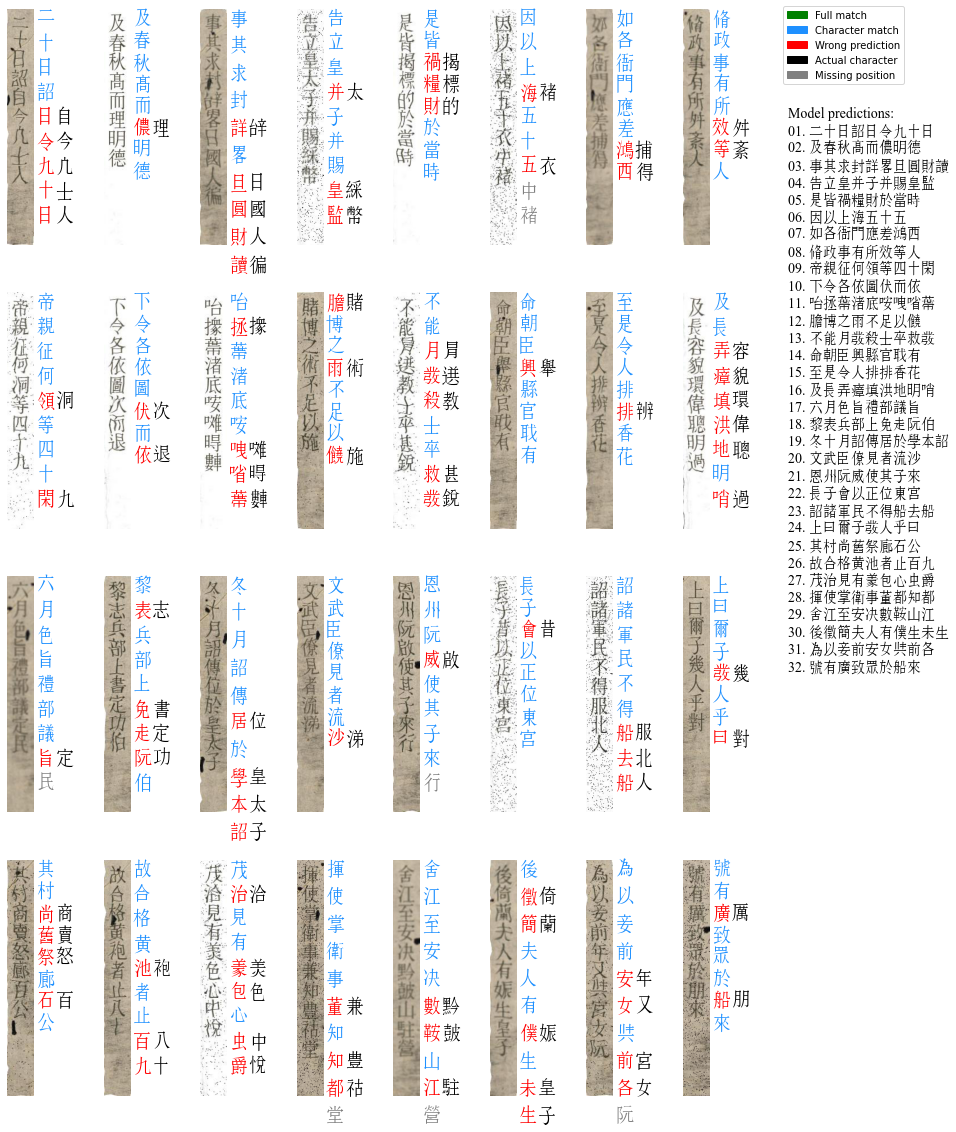

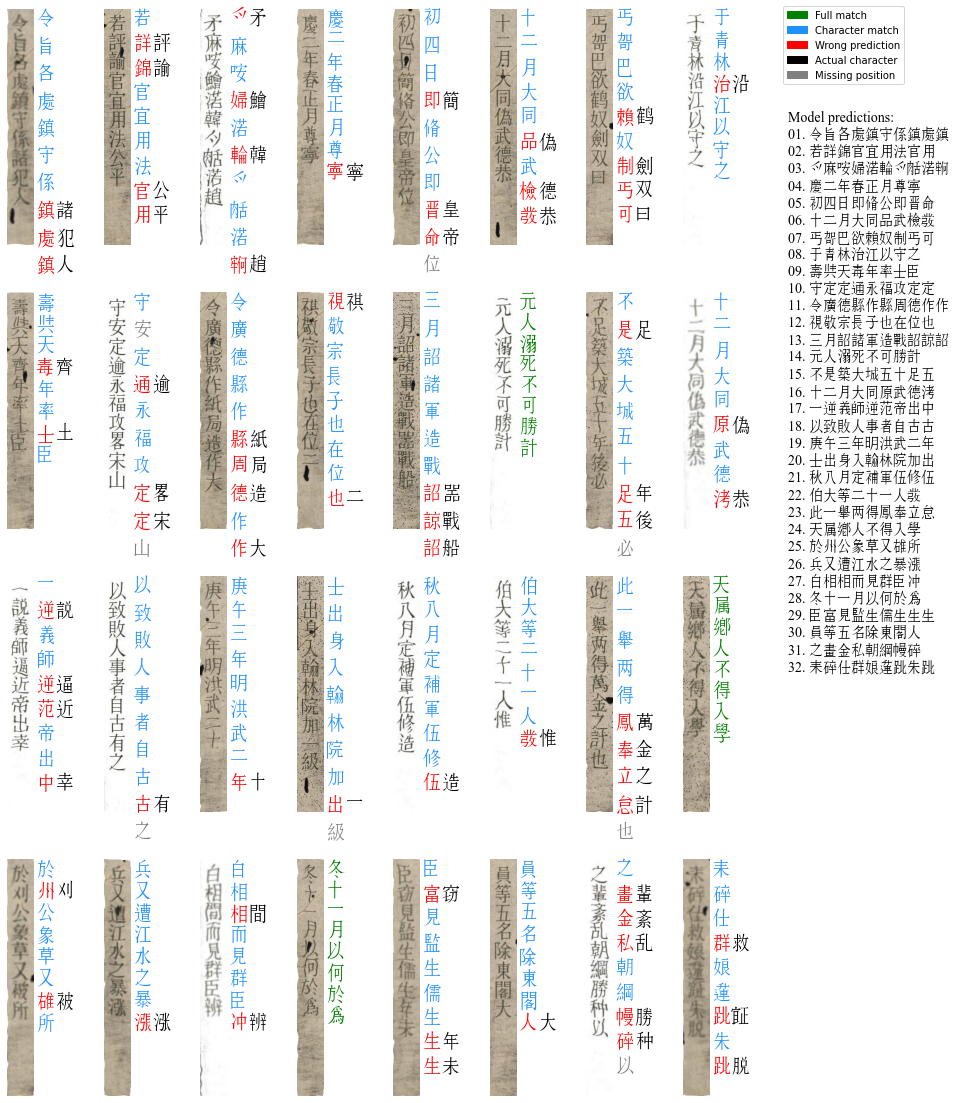

In [32]:
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(2)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens = reset_model.predict(batch_images)
    pred_labels = data_handler.tokens2texts(pred_tokens)
    
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (14, 20),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.28),
        annotate_loc = (4, 1.8),
        font_path = FONT_PATH, 
        text_x = WIDTH + 5 # Position of actual label to plot
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [33]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens)

Predicted text: 固𦝄𪜀𥺊经沒恩𢚸𢚸


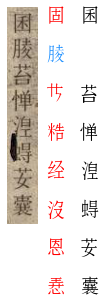

In [34]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
    text_x = 40 # Position to plot actual label
)
print('Predicted text:', ''.join(pred_labels))